In [7]:
# computer algebra library
import symengine
import sympy
sympy.init_printing()

# jupyter notebook display library
from IPython.display import display as IPyDisplay
from IPython.display import Latex

# numeric integration library
import scipy
from scipy.integrate import solve_ivp

# plotting library
from matplotlib.pyplot import plot, legend, show
# from sympy.plotting import plot

# library for scientific computing, used here for plotting
import numpy as np

from sympy import Symbol, Function, Eq, dsolve

from scipy import integrate

from lmfit import Model

## Model definition
Let's define a system of 2 equations with variables `x` and `y` and parameters `a,b,c,d`:

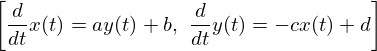

In [8]:
a,b,c,d,t,x0,y0 = sympy.symbols("a b c d t x0 y0")
x = Function('x')(t)
y = Function('y')(t)
edo1 = Eq(x.diff(t),a*y+b)
edo2 = Eq(y.diff(t),-c*x+d)
system = [edo1, edo2]
system

## Data simulation from numeric solution
We first solve it numerically to generate simulated data with actual paramater values 1,2,3 and 4 for, respectively, `a,b,c` and `d`, and initial conditions `x(0)=0` and `y(0)=0`:

In [9]:
eqnf = [ 
            sympy.lambdify((t,x,y), edo1.args[1].subs(a,1).subs(b,2), modules='sympy'), 
            sympy.lambdify((t,x,y), edo2.args[1].subs(c,3).subs(d,4), modules='sympy')
       ]
def numsys(t,y,*kargs, **kwargs): return [ eqn(t,*y) for eqn in eqnf ]
sol_num = solve_ivp(numsys, (0,10), [0,0], method="LSODA",  dense_output=True)

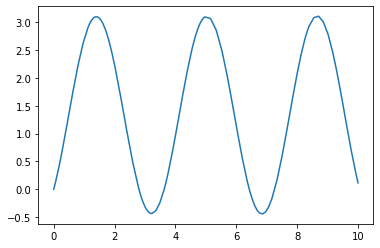

In [10]:
plot(sol_num.t,sol_num.y[0])
#plot(sol_num.t,sol_num.y[1])

To call the numerical solution as a function, we use the attribute `sol`, for instance with a value 3.4:

In [11]:
sol_num.sol(3.5)

array([-0.22701104, -0.55352257])

We obtain a value for both `x` anf `y`.

Now, we can simulate our fake data:

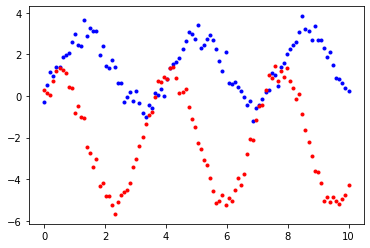

In [12]:
interv = scipy.linspace(0, 10, 100)
fake_data = [sol_num.sol(interv)[0] + np.random.normal(0,0.3,100),sol_num.sol(interv)[1] + np.random.normal(0,0.3,100)] 
plot(interv,fake_data[0], 'b.')
plot(interv,fake_data[1], 'r.')

## Parameter estimation

In [13]:
eqnf = [ 
            sympy.lambdify((t,x,y,a,b,c,d), edo1.args[1], modules='sympy'), 
            sympy.lambdify((t,x,y,a,b,c,d), edo2.args[1], modules='sympy')
       ]
def numsys(t,y,*kargs, **kwargs): return [ eqn(t,*y,kwargs['a'],kwargs['b'],kwargs['c'],kwargs['d']) for eqn in eqnf ]

We will fit both `x` and `y` against `fake_data`, thus `myFunction` returns the list `[x(t),y(t)]`.  

In [14]:
def myFunction(t,a,b,c,d):
    sol_num = solve_ivp(lambda t,y: numsys(t,y,**{'a':a,'b':b,'c':c,'d':d}), (0,10), [0,0], method="LSODA", dense_output=True)
    return sol_num.sol(t)

model = Model(myFunction)
print('parameter names: {}'.format(model.param_names))
print('independent variables: {}'.format(model.independent_vars))

parameter names: ['a', 'b', 'c', 'd']
independent variables: ['t']


Let's create the parameters within the model:

In [15]:
params = model.make_params()
params['a'].set(min=-5, max=5)
params['b'].set(min=-5, max=5)
params['c'].set(min=-5, max=5)
params['d'].set(min=-5, max=5)

Note that if we don't fix min and max values for the parameters, the following fit fails...  

In [27]:
Y = model.eval(a=1,b=2,c=3,d=4,t=interv)

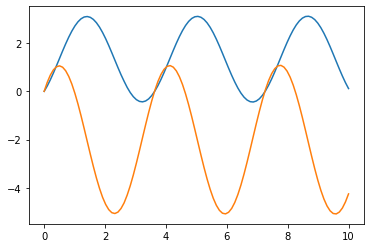

In [20]:
plot(interv,Y[0])
plot(interv,Y[1])

In [14]:
result = model.fit(fake_data,params,t=interv,method='differential_evolution')
#result = model.fit(fake_data,params,t=interv)
print(result.fit_report())

[[Model]]
    Model(myFunction)
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 2970
    # data points      = 200
    # variables        = 4
    chi-square         = 17.2372503
    reduced chi-square = 0.08794515
    Akaike info crit   = -482.248922
    Bayesian info crit = -469.055652
##  Warning: uncertainties could not be estimated:
    this fitting method does not natively calculate uncertainties
    and numdifftools is not installed for lmfit to do this. Use
    `pip install numdifftools` for lmfit to estimate uncertainties
    with this fitting method.
[[Variables]]
    a:  0.97852959 (init = -5)
    b:  1.94452819 (init = -5)
    c:  3.07691982 (init = -5)
    d:  4.09828199 (init = -5)


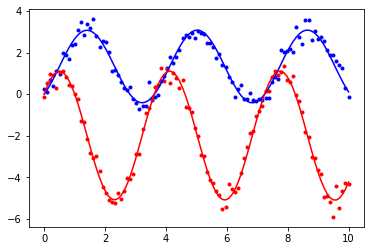

In [15]:
plot(interv,fake_data[0], 'b.')
plot(interv,fake_data[1], 'r.')
#plot(interv, result.init_fit[0], 'k--', label='initial fit')
plot(interv, result.best_fit[0], 'b-', label='best fit')
plot(interv, result.best_fit[1], 'r-', label='best fit')
#legend(loc='best')
show()

## Sensitivity Analysis

We use the module [SALib](https://salib.readthedocs.io/en/latest/).

In [2]:
from SALib.sample import saltelli
from SALib.analyze import sobol

#### Model inputs

In [62]:
problem = {
    'num_vars': 4,
    'names': ['a', 'b', 'c', 'd'],
    'bounds': [[-5, 5],
               [-5, 5],
               [-5, 5],
               [-5, 5]]
}

#### Generate samples

In [63]:
param_values = saltelli.sample(problem, 1000)

#### Run the model

In [65]:
Y = np.zeros([param_values.shape[0]])

In [66]:
for i, P in enumerate(param_values):
    Y[i] = model.eval(a=P[0],b=P[1],c=P[2],d=P[3],t=[0.5])[0]

#### Perform analysis

In [68]:
Si = sobol.analyze(problem, Y)

In [70]:
print(Si['S1'])

[1.05978382e-03 6.05202760e-01 1.26563593e-04 1.06868497e-02]


In [71]:
print(Si['S2'])

[[        nan -0.01372722  0.01339895  0.31456154]
 [        nan         nan -0.00444475 -0.00427885]
 [        nan         nan         nan  0.0053824 ]
 [        nan         nan         nan         nan]]


In [73]:
print(Si['ST'])

[0.38650051 0.67983015 0.08011059 0.32324917]
